# **Using Residual Sugar, Citric Acid and Volatile Acidity to judge a wine's quality.**
#### Leewana Nanda,
#### Arjun Bhatia, 
#### Maya Tharp, 
#### Sue Dong

## Introduction


Wine quality can be determined by a number of factors, ranging from physicochemical properties, such as residual
sugar, to sensory properties, like aroma, color and flavor. However, it is the interaction between the 
physicochemical properties and the sensory properties that allows for a judgment to be made regarding the quality
of the wine (Gutiérrez-Escobar et al., 2021). This project will investigate if physicochemical properties of sweet
red wine can predict the quality of the red wine. The dataset chosen is “Wine Quality” from UC Irvine and it is a 
multivariate dataset. The dataset has twelve variables in total, including the target “quality” variable and looks
at several physicochemical properties. 

Hypothesis: Higher levels of indicators of sweetness (volatile acidity, residual sugar, citric acid) correspond to higher quality and these 3 can be used to accurately predict the quality of a wine. 

[provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report,
clearly state the question you tried to answer with your project,
identify and describe the dataset that was used to answer the question]



## Methods

###  Importing libraries

In [19]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
options(repr.plot.width = 10, repr.plot.height = 7)

....

###  Reading the data

In [76]:
#Reading the data fom the URL 
wine_data <- read.csv2("http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv")

wine_data 

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
7.4,0.7,0,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.8,0.88,0,2.6,0.098,25,67,0.9968,3.2,0.68,9.8,5
7.8,0.76,0.04,2.3,0.092,15,54,0.997,3.26,0.65,9.8,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
6.3,0.51,0.13,2.3,0.076,29,40,0.99574,3.42,0.75,11,6
5.9,0.645,0.12,2,0.075,32,44,0.99547,3.57,0.71,10.2,5
6,0.31,0.47,3.6,0.067,18,42,0.99549,3.39,0.66,11,6


Observations about data

###  Plotting the frequency of qualities in the dataset

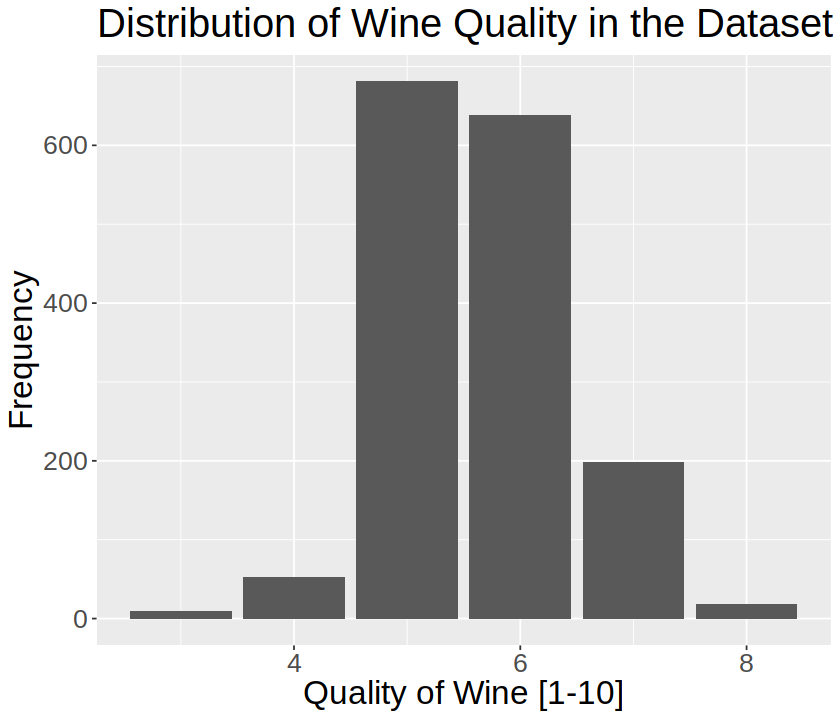

In [77]:
options(repr.plot.width = 7, repr.plot.height = 6)

quality_distribution <- wine_data |>
                        ggplot(aes(x = quality)) +
                        geom_bar() +
                        labs(x = "Quality of Wine [1-10]", y = "Frequency") +
                        ggtitle("Distribution of Wine Quality in the Dataset") +
                        theme(text = element_text(size = 20))

quality_distribution

Inference drawn from graph

###  Selecting the parameters we need and converting them from 'chr' to 'numeric' and 'factor'

In [78]:
#Selecting the variables we will need for our analysis and then converitng them to the right type.

wine_data <- select(wine_data, volatile.acidity, citric.acid, residual.sugar, quality)

wine_data <- mutate(wine_data, volatile.acidity = as.numeric(volatile.acidity),
                               citric.acid      = as.numeric(citric.acid),
                               residual.sugar   = as.numeric(residual.sugar),
                               quality          = as.factor(quality))
             
str(wine_data)



'data.frame':	1599 obs. of  4 variables:
 $ volatile.acidity: num  0.7 0.88 0.76 0.28 0.7 0.66 0.6 0.65 0.58 0.5 ...
 $ citric.acid     : num  0 0 0.04 0.56 0 0 0.06 0 0.02 0.36 ...
 $ residual.sugar  : num  1.9 2.6 2.3 1.9 1.9 1.8 1.6 1.2 2 6.1 ...
 $ quality         : Factor w/ 6 levels "3","4","5","6",..: 3 3 3 4 3 3 3 5 5 3 ...


Explain

### Setup for classification  

In [79]:
#Splitting the data set into training and testing
set.seed(123456)

wine_split <- initial_split(wine_data, prop = 0.75, strata = quality)
wine_training <- training(wine_split)
wine_testing <- testing(wine_split)

In [80]:
#Creating classification recipe
set.seed(123456)

wine_recipe <- recipe(quality ~ . , data = wine_training)|>
               step_center(all_predictors())|>
               step_scale(all_predictors())
wine_recipe


Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Operations:

Centering for all_predictors()
Scaling for all_predictors()

In [81]:
# V-fold and knn tune setup
set.seed(123456)

wine_vfold <- vfold_cv(wine_training, v = 5, strata = quality)

wine_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
             set_engine("kknn") |>
             set_mode("classification")

wine_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Choosing the optimal number of neighbors for classification

In [82]:
set.seed(123456)

knn_results <- workflow() |>
               add_recipe(knn_recipe) |>
               add_model(knn_tune) |>
               tune_grid(resamples = vfold, grid = 20)|>
               collect_metrics()
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.4970252,5,0.008636373,Preprocessor1_Model01
1,roc_auc,hand_till,0.5674487,5,0.005415391,Preprocessor1_Model01
2,accuracy,multiclass,0.4970287,5,0.008485459,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
13,roc_auc,hand_till,0.6250791,5,0.02070546,Preprocessor1_Model13
14,accuracy,multiclass,0.4903130,5,0.01000624,Preprocessor1_Model14
14,roc_auc,hand_till,0.6349618,5,0.01820167,Preprocessor1_Model14


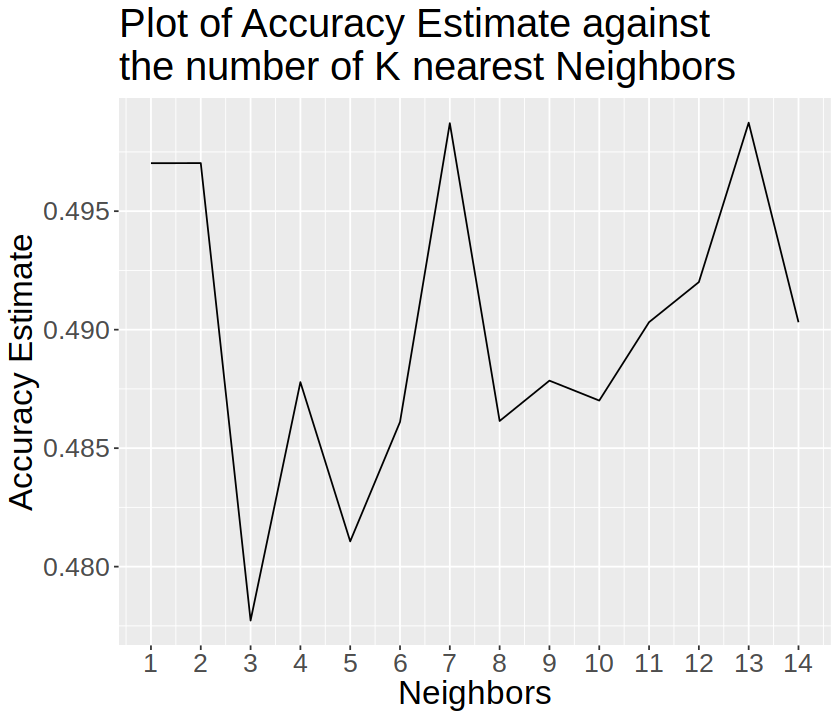

In [86]:
set.seed(123456)


accuracies <- knn_results |> 
              filter(.metric == "accuracy")

accuracies_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
                  geom_line() +
                  labs(x = "Neighbors", y = "Accuracy Estimate", title = "Plot of Accuracy Estimate against
the number of K nearest Neighbors") +
                  scale_x_continuous(breaks = seq(0, 100, by = 1)) +  
                  theme(text = element_text(size = 20)) 

accuracies_plot

Using 7 neighbours

In [87]:
set.seed(1234)

wine_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
             set_engine("kknn") |>
             set_mode("classification")

wine_fit <- workflow()|>
            add_recipe(wine_recipe)|>
            add_model(wine_spec)|>
            fit(data = wine_training)

wine_spec
wine_fit

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 7
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_center()
• step_scale()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(7,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.5183639
Best kernel: rectangular
Best k: 7

In [91]:
wine_predictions <- wine_fit|>
                    predict(wine_testing)|>
                    bind_cols(wine_testing) 
wine_predictions

wine_metrics <- wine_predictions|>
                metrics(truth = quality, estimate = .pred_class) 
wine_metrics


.pred_class,volatile.acidity,citric.acid,residual.sugar,quality
<fct>,<dbl>,<dbl>,<dbl>,<fct>
6,0.28,0.56,1.9,6
5,0.58,0.08,1.8,5
5,0.62,0.19,3.9,5
⋮,⋮,⋮,⋮,⋮
5,0.67,0.15,1.8,6
5,0.56,0.09,1.7,5
5,0.74,0.09,1.7,6


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.4987531
kap,multiclass,0.1865962


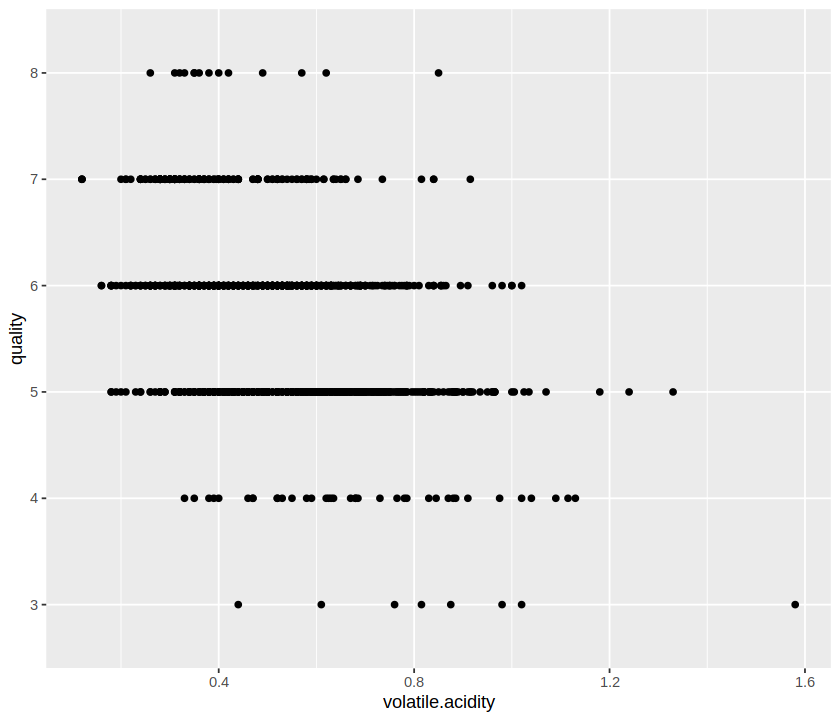

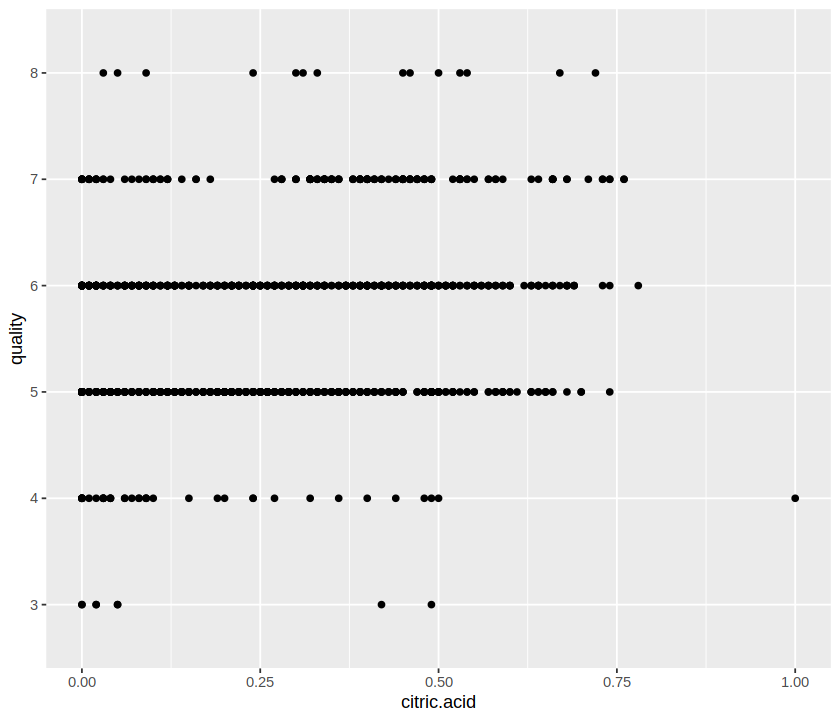

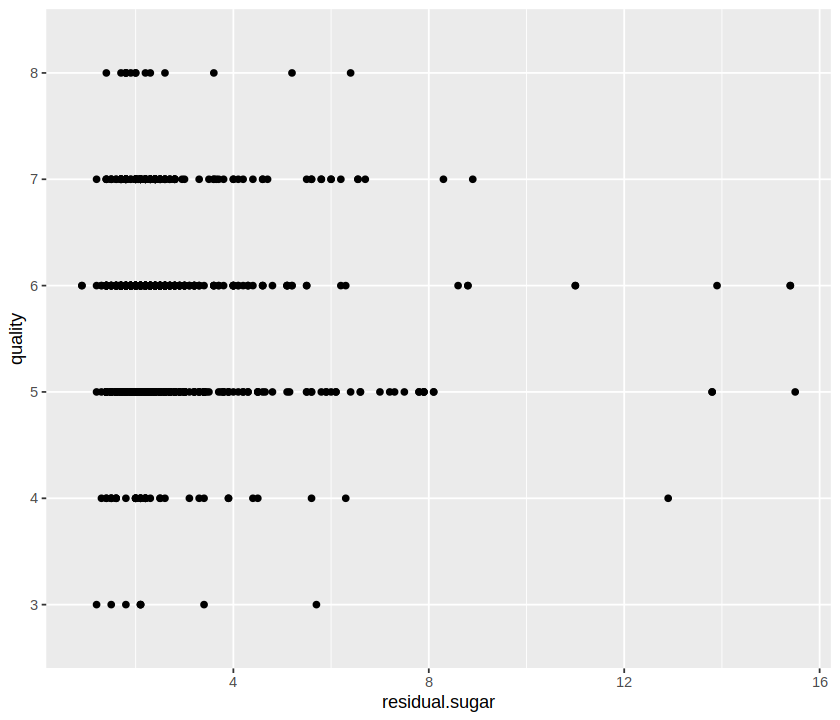

In [96]:
ggplot(wine_training, aes(x = volatile.acidity, y = quality)) + geom_point()
ggplot(wine_training, aes(x = citric.acid, y = quality)) + geom_point()
ggplot(wine_training, aes(x = residual.sugar, y = quality)) + geom_point()

Findings : accuracy is too low so these 3 alone cant classify wine reliably, the probelm is also the data since it is very unbalanced, almost no observations for 3 and almnost the name sumber of observations for 5 and 6. Maybe this question can still hold true but we would need more balanced data or to pursue oversampling of the less prevelant qualities. Infact the findings of the model are opposite as shown in the 3 scatter plots above. We are getting such biased reaults because 

a) levels of these indicators are pretty much the same

b) there isn't much observatinal variety

c) one solution is to group qualities together into an interval like [3,5), (5,7), [7, 9]